In [1]:
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from CaT.model import CaT
from CaT.datasets import reorder_dag, get_full_ordering
from CFCN.model import CFCN
from utils.inference import CausalInference
from eval_utils import train_model
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import pandas as pd

mse_figname = 'mse_all.png'
ate_figname = 'ate_all.png'


test_CAT = True
test_CFCN = True
test_RF = True
test_transformer = True
test_MLP = True

num_sims = 1

seed = 1
standardize = 0
sample_size = 100000
batch_size = 100
max_iters = 6000
eval_interval = 20000
eval_iters = 100
validation_fraction = 0.3
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate_cat = 0.0
learning_rate_cat = 5e-3
ff_n_embed = 6
num_heads = 2
n_layers = 2
embed_dim = 5
head_size = 6


# CFCN stuff
neurons_per_layer = [4,8,8,8, 8, 4]
dropout_rate_cfcn = 0.0
learning_rate_cfcn = 1e-3
max_iters_cfcn = 20000
shuffling = 0

In [14]:
def generate_data(N, d=1):
    DAGnx1 = nx.DiGraph()
    DAGnx2 = nx.DiGraph()
    DAGnx3 = nx.DiGraph()  # correct graph
    
    Ud = np.random.randn(N,d)
    D =  Ud
    
    Ul1 = np.random.randn(N,d) #  D ->  L1 = 0.5
    L1 =  0.5*D + Ul1
    
    L1_0 = Ul1
    L1_1 = 0.5 + Ul1  #  D ->  L1 = 0.5

    Uy = np.random.randn(N,d)
    Y =   0.5*D + 3.5 * L1 + Uy  #  D ->  Y = 1, L1 -> Y = 1.2,  ATE(Y|do(D=1)) = 0.5*3.5 + 0.5 = 1.75 + 0.5 = 2.25 

    Ul2 = np.random.randn(N,d)
    L2 = 0.9 * Y + 0.7 * D + Ul2  #  D ->  L2 = 0.7, Y -> L2 = 9.8

    Y0 = 3.5 * L1_0 + Uy 
    Y1 = 0.5 + 3.5 * L1_1 + Uy

    all_data_dict = {'D': D, 'L1': L1, 'Y': Y, 'L2': L2}  

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'D': 'cont', 'L1': 'cont',  'Y': 'cont', 'L2': 'cont',}

    DAGnx1.add_edges_from([('D', 'Y'), ('L1', 'Y'), ('L2', 'Y')])
    DAGnx1 = reorder_dag(dag=DAGnx1)  # topologically sorted dag
    var_names1 = list(DAGnx1.nodes())  # topologically ordered list of variables
    all_data1 = np.stack([all_data_dict[key] for key in var_names1], axis=1)
    causal_ordering1 = get_full_ordering(DAGnx1)
    ordered_var_types1 = dict(sorted(var_types.items(), key=lambda item: causal_ordering1[item[0]]))
    ex_dag_stuff = (all_data1, DAGnx1, var_names1, causal_ordering1, ordered_var_types1)
    
    DAGnx2.add_edges_from([('D', 'L1'), ('D', 'Y'), ('L1', 'Y'), ('L2', 'Y')])
    DAGnx2 = reorder_dag(dag=DAGnx2)  # topologically sorted dag
    var_names2 = list(DAGnx2.nodes())  # topologically ordered list of variables
    all_data2 = np.stack([all_data_dict[key] for key in var_names2], axis=1)
    causal_ordering2 = get_full_ordering(DAGnx2)
    ordered_var_types2 = dict(sorted(var_types.items(), key=lambda item: causal_ordering2[item[0]]))
    mediated_dag_stuff = (all_data2, DAGnx2, var_names2, causal_ordering2, ordered_var_types2)
    
    DAGnx3.add_edges_from([('D', 'Y'), ('D', 'L1'),  ('L1', 'Y') , ('D', 'L2'), ('Y', 'L2')])
    DAGnx3 = reorder_dag(dag=DAGnx3)  # topologically sorted dag
    var_names3 = list(DAGnx3.nodes())  # topologically ordered list of variables
    all_data3 = np.stack([all_data_dict[key] for key in var_names3], axis=1)  # sorted data
    causal_ordering3 = get_full_ordering(DAGnx3)
    ordered_var_types3 = dict(sorted(var_types.items(), key=lambda item: causal_ordering3[item[0]]))
    correct_dag_stuff =  (all_data3, DAGnx3, var_names3, causal_ordering3, ordered_var_types3)

    return ex_dag_stuff, mediated_dag_stuff, correct_dag_stuff, Y0, Y1


def apply_random_forest(train_data, val_data, all_data, cause_index, effect_index):
    rf = RandomForestRegressor()
    
    # Prepare the training data: Input = all variables except effect_index, target = effect_index
    X_train = train_data[:, np.arange(train_data.shape[1]) != effect_index, 0].numpy()  # Select all variables except effect_index
    y_train = train_data[:, effect_index, 0].numpy()  # Target is the effect_index variable

    # Train the RandomForest on the training data
    rf.fit(X_train, y_train)

    # 1st: Predict on the validation set to compute the MSE
    X_val = val_data[:, np.arange(val_data.shape[1]) != effect_index, 0].numpy()  # Input without effect_index
    y_val = val_data[:, effect_index, 0].numpy()  # True effect values for validation

    preds_val = rf.predict(X_val)
    mse = ((y_val - preds_val) ** 2).mean()

    # 2nd: Copy the all_data (numpy array), and set cause_index to 0 and 1 in two copies
    all_data0 = np.copy(all_data)
    all_data1 = np.copy(all_data)

    all_data0[:, cause_index, 0] = 0  # Set cause_index to 0
    all_data1[:, cause_index, 0] = 1  # Set cause_index to 1

    # Prepare the intervention data for prediction: all variables except effect_index
    X_all_data0 = all_data0[:, np.arange(all_data.shape[1]) != effect_index, 0]  # Inputs for intervention where cause is 0
    X_all_data1 = all_data1[:, np.arange(all_data.shape[1]) != effect_index, 0]  # Inputs for intervention where cause is 1

    # Predict for the intervention datasets (cause set to 0 and 1)
    preds0 = rf.predict(X_all_data0)
    preds1 = rf.predict(X_all_data1)

    # 3rd: Compute the estimated ATE (Average Treatment Effect)
    estimated_ATE = (preds1 - preds0).mean()

    print('RF MSE on validation set:', mse)
    print('RF Estimated ATE:', estimated_ATE)

    return estimated_ATE, mse, rf

    
def apply_mlp(train_data, val_data, all_data, cause_index, effect_index):
    mlp = MLPRegressor(max_iter=max_iters, hidden_layer_sizes=(20,20,20), activation='relu')
    
    X_train = train_data[:, np.arange(train_data.shape[1]) != effect_index, 0].numpy()  # Select all variables except effect_index
    y_train = train_data[:, effect_index, 0].numpy()  # Target is the effect_index variable

    # Train the MLP on the training data
    mlp.fit(X_train, y_train)

    # 1st: Predict on the validation set to compute the MSE
    X_val = val_data[:, np.arange(val_data.shape[1]) != effect_index, 0].numpy()  # Input without effect_index
    y_val = val_data[:, effect_index, 0].numpy()  # True effect values for validation

    preds_val = mlp.predict(X_val)
    mse = ((y_val - preds_val) ** 2).mean()

    # 2nd: Copy the all_data (numpy array), and set cause_index to 0 and 1 in two copies
    all_data0 = np.copy(all_data)
    all_data1 = np.copy(all_data)

    all_data0[:, cause_index, 0] = 0  # Set cause_index to 0
    all_data1[:, cause_index, 0] = 1  # Set cause_index to 1

    # Prepare the intervention data for prediction: all variables except effect_index
    X_all_data0 = all_data0[:, np.arange(all_data.shape[1]) != effect_index, 0]  # Inputs for intervention where cause is 0
    X_all_data1 = all_data1[:, np.arange(all_data.shape[1]) != effect_index, 0]  # Inputs for intervention where cause is 1

    # Predict for the intervention datasets (cause set to 0 and 1)
    preds0 = mlp.predict(X_all_data0)
    preds1 = mlp.predict(X_all_data1)

    # 3rd: Compute the estimated ATE (Average Treatment Effect)
    estimated_ATE = (preds1 - preds0).mean()

    print('MLP MSE on validation set:', mse)
    print('MLP Estimated ATE:', estimated_ATE)

    return estimated_ATE, mse, mlp



class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, n_layers=2, n_heads=2):
        super(TransformerRegressor, self).__init__()
        # Define an encoder layer with the hidden_dim (embedding dimension)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads, dim_feedforward=hidden_dim, batch_first=True)
        # Stack the encoder layers into a TransformerEncoder
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        # Project input_dim to hidden_dim for input embeddings
        self.embedding = nn.Linear(input_dim, hidden_dim)
        # Fully connected layer for final regression output (projecting hidden_dim to 1)
        self.fc = nn.Linear((input_dim) * hidden_dim, 1) # Output a scalar per input sample

    def forward(self, x):
        # Project input_dim to hidden_dim
        x = self.embedding(x)  # (batch_size, num_variables, hidden_dim)
        # Pass input through the transformer encoder
        out = self.transformer_encoder(x)  # (batch_size, num_variables, hidden_dim)
        # Flatten the sequence dimension and pass through fully connected layer
        out = out.view(out.size(0), -1)  # Flatten to (batch_size, num_variables * hidden_dim)
        # Fully connected layer to output a prediction
        out = self.fc(out)  # Adjust self.fc to match the flattened size
        return out.squeeze(-1)  # (N,)
    

def create_data_loader(train_data, batch_size, effect_index):
    # All variables except the one at effect_index
    X_train = train_data[:, np.arange(train_data.shape[1]) != effect_index, 0]  
    # Target is the effect_index variable
    y_train = train_data[:, effect_index, 0]
    
    dataset = TensorDataset(X_train, y_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader   
    
    
def apply_transformer(train_data, val_data, all_data, cause_index, effect_index, batch_size, max_iters, device):
    input_dim = train_data.shape[1] - 1  # V dimension corresponds to the number of variables excluding effect_index
    transformer = TransformerRegressor(input_dim=input_dim).to(device)
    optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    # Prepare the training data with batching
    train_loader = create_data_loader(train_data, batch_size=batch_size, effect_index=effect_index)
    train_loader_iter = iter(train_loader)  # Create an iterator from the loader

    # Training Loop
    transformer.train()

    for iter_ in range(max_iters):
        try:
            # Try getting the next batch
            batch_X, batch_y = next(train_loader_iter)
        except StopIteration:
            # If the iterator is exhausted, recreate the iterator (i.e., reshuffle and restart)
            train_loader_iter = iter(train_loader)
            batch_X, batch_y = next(train_loader_iter)

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
    
        # Pass batch_X to transformer with the correct shape (N, V-1, input_dim)
        batch_X = batch_X.unsqueeze(-1).repeat(1, 1, input_dim)  # Repeat input_dim times if needed

        preds = transformer(batch_X)  # Directly pass the features (N, V-1)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()

        # Optionally, print loss every 100 iterations for monitoring
        if iter_ % eval_interval == 0:
            print(f"Iteration {iter_}/{max_iters}, Loss: {loss.item():.4f}")
            
    X_val = val_data[:, np.arange(val_data.shape[1]) != effect_index, 0].to(device)  # Input without effect_index
    X_val = X_val.unsqueeze(-1).repeat(1, 1, input_dim)
    y_val = val_data[:, effect_index, 0].to(device)  # True effect values for validation
    

    transformer.eval()
    with torch.no_grad():
        preds_val = transformer(X_val).detach().cpu().numpy()
        
    
    mse = ((y_val.cpu().numpy() - preds_val) ** 2).mean()

    # 2nd: Copy the all_data (numpy array), and set cause_index to 0 and 1 in two copies
    all_data0 = np.copy(all_data)
    all_data1 = np.copy(all_data)

    all_data0[:, cause_index, 0] = 0  # Set cause_index to 0
    all_data1[:, cause_index, 0] = 1  # Set cause_index to 1

    # Prepare the intervention data for prediction: all variables except effect_index
    X_all_data0 = torch.from_numpy(all_data0[:, np.arange(all_data.shape[1]) != effect_index, 0]).float().to(device)
    X_all_data0 = X_all_data0.unsqueeze(-1).repeat(1, 1, input_dim)
    X_all_data1 = torch.from_numpy(all_data1[:, np.arange(all_data.shape[1]) != effect_index, 0]).float().to(device)
    X_all_data1 = X_all_data1.unsqueeze(-1).repeat(1, 1, input_dim)

    torch.cuda.empty_cache()

    # Predict for the intervention datasets (cause set to 0 and 1)
    transformer.eval()
    with torch.no_grad():
        preds0 = transformer(X_all_data0).detach().cpu().numpy()
        preds1 = transformer(X_all_data1).detach().cpu().numpy()

    # 3rd: Compute the estimated ATE (Average Treatment Effect)
    estimated_ATE = (preds1 - preds0).mean()

    print('Transformer MSE on validation set:', mse)
    print('Transformer Estimated ATE:', estimated_ATE)

    return estimated_ATE, mse, transformer






In [59]:

d=1
_, _, _, Y0, Y1 = generate_data(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  
print(ATE)
ATE_samples = []

cause_var = 'D'
int_nodes_vals0 = {cause_var: np.array([0.0,])}
int_nodes_vals1 = {cause_var: np.array([1.0,])}
effect_var = 'Y'


if test_CAT:
    mse_y_1s_CaT = []
    mse_y_2s_CaT = []
    mse_y_3s_CaT = []
    est_ATE_1s_CaT = []
    est_ATE_2s_CaT = []
    est_ATE_3s_CaT = []

if test_CFCN:
    mse_y_1s_CFCN = []
    mse_y_2s_CFCN = []
    mse_y_3s_CFCN = []
    est_ATE_1s_CFCN = []
    est_ATE_2s_CFCN = []
    est_ATE_3s_CFCN = []

if test_RF:
    mse_y_RF = []
    est_ATE_RF = []

if test_transformer:
    mse_y_transformer = []
    est_ATE_transformer = []

if test_MLP:
    mse_y_MLP = []
    est_ATE_MLP = []

for i in range(num_sims):
    print('Simulation:', i)
    
    ex_dag_stuff, mediated_dag_stuff, correct_dag_stuff, Y0, Y1 = generate_data(N=sample_size, d=d)
    ATE_samples.append((Y1-Y0).mean())
    print('ATE sample:', (Y1-Y0).mean())
    
    all_data1, DAGnx1, var_names1, causal_ordering1, var_types1 = ex_dag_stuff
    all_data2, DAGnx2, var_names2, causal_ordering2, var_types2 = mediated_dag_stuff
    all_data3, DAGnx3, var_names3, causal_ordering3, var_types3 = correct_dag_stuff
    
    indices = np.arange(0, len(all_data3))
    np.random.shuffle(indices)
    val_inds = indices[:int(validation_fraction*len(indices))]
    train_inds = indices[int(validation_fraction*len(indices)):]
    

    train_data = all_data1[train_inds]
    val_data = all_data1[val_inds]
    train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()
    effect_index = var_names1.index(effect_var)
    cause_index = var_names1.index(cause_var)    

    input_dim = all_data1.shape[2]

    if test_CFCN:
        print('Training CFCN on graph 1...')
        model1_cfcn = CFCN(neurons_per_layer=neurons_per_layer, dag=DAGnx1, causal_ordering=causal_ordering1, var_types=var_types1, dropout_rate=dropout_rate_cfcn).to(device)
        train_model(model1_cfcn, train_data, val_data, device, shuffling=shuffling, max_iters=max_iters_cfcn, eval_interval=eval_interval, eval_iters=eval_iters, learning_rate=learning_rate_cfcn, batch_size=batch_size, use_scheduler=False)
        model1_cfcn.eval()    
        inf = CausalInference(model=model1_cfcn, device=device)
        effect_index = var_names1.index(effect_var)
        preds0 = inf.forward(all_data1, int_nodes_vals0)
        preds1 = inf.forward(all_data1, int_nodes_vals1)
        ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
        eATE = np.abs(ATE_pred - ATE)
        preds = model1_cfcn(val_data.to(device)).detach().cpu()
        mse_y_1s_CFCN.append(((val_data[:,effect_index,:] - preds[:,effect_index,:])**2).mean())
        est_ATE_1s_CFCN.append(ATE_pred)
        print('CFCN1 ATE:', ATE_pred)
        print('CFCN1 MSE:', ((val_data[:,effect_index,:] - preds[:,effect_index,:])**2).mean())

    if test_CAT:
        print('Training CaT on graph 1...')
        model1 = CaT(input_dim=input_dim,
                        dropout_rate=dropout_rate_cat,
                        head_size=head_size,
                        num_heads=num_heads,
                        ff_n_embed=ff_n_embed,
                        dag=DAGnx1,
                        causal_ordering=causal_ordering1,
                        n_layers=n_layers,
                        device=device,
                        var_types=var_types1,
                        use_batch_norm=False,
                        embed_dim=embed_dim
                        ).to(device)
        train_model(model1, train_data, val_data, device, shuffling=0, max_iters=max_iters, eval_interval=eval_interval, eval_iters=eval_iters, learning_rate=learning_rate_cat, batch_size=batch_size)
        model1.eval()
        inf = CausalInference(model=model1, device=device)
        effect_index = var_names1.index(effect_var)
        preds0 = inf.forward(all_data1, int_nodes_vals0)
        preds1 = inf.forward(all_data1, int_nodes_vals1)
        ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
        eATE = np.abs(ATE_pred - ATE)
        preds = model1(val_data.to(device)).detach().cpu()
        mse_y_1s_CaT.append(((val_data[:,effect_index,:] - preds[:,effect_index,:])**2).mean())
        est_ATE_1s_CaT.append(ATE_pred)
        print('CAT1 ATE:', ATE_pred)
        print('CAT1 MSE:', ((val_data[:,effect_index,:] - preds[:,effect_index,:])**2).mean())


    train_data = all_data2[train_inds]
    val_data = all_data2[val_inds]
    train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()
    effect_index = var_names2.index(effect_var)
    cause_index = var_names2.index(cause_var)

    input_dim = all_data2.shape[2]

    print('Training CFCN on graph 2...')
    if test_CFCN:
        print('Training CFCN on graph 2...')
        model2_cfcn = CFCN(neurons_per_layer=neurons_per_layer, dag=DAGnx2, causal_ordering=causal_ordering2, var_types=var_types2, dropout_rate=dropout_rate_cfcn).to(device)
        train_model(model2_cfcn, train_data, val_data, device, shuffling=shuffling, max_iters=max_iters_cfcn, eval_interval=eval_interval, eval_iters=eval_iters, learning_rate=learning_rate_cfcn, batch_size=batch_size, use_scheduler=False)
        model2_cfcn.eval()
        inf = CausalInference(model=model2_cfcn, device=device)
        effect_index = var_names2.index(effect_var)
        preds0 = inf.forward(all_data2, int_nodes_vals0)
        preds1 = inf.forward(all_data2, int_nodes_vals1)
        ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
        eATE = np.abs(ATE_pred - ATE)
        preds = model2_cfcn(val_data.to(device)).detach().cpu()
        mse_y_2s_CFCN.append(((val_data[:,effect_index,:] - preds[:,effect_index,:])**2).mean())
        est_ATE_2s_CFCN.append(ATE_pred)

        print('CFCN2 ATE:', ATE_pred)
        print('CFCN2 MSE:', ((val_data[:,effect_index,:] - preds[:,effect_index,:])**2).mean())


    if test_CAT:
        print('Training CaT on graph 2...')
        model2 = CaT(input_dim=input_dim,
                        dropout_rate=dropout_rate_cat,
                        head_size=head_size,
                        num_heads=num_heads,
                        ff_n_embed=ff_n_embed,
                        dag=DAGnx2,
                        causal_ordering=causal_ordering2,
                        n_layers=n_layers,
                        device=device,
                        var_types=var_types2,
                        use_batch_norm=False,
                        embed_dim=embed_dim
                        ).to(device)
        train_model(model2, train_data, val_data, device, shuffling=0, max_iters=max_iters, eval_interval=eval_interval, eval_iters=eval_iters, learning_rate=learning_rate_cat, batch_size=batch_size)
        model2.eval()
        inf = CausalInference(model=model2, device=device)
        effect_index = var_names2.index(effect_var)
        preds0 = inf.forward(all_data2, int_nodes_vals0)
        preds1 = inf.forward(all_data2, int_nodes_vals1)
        ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
        eATE = np.abs(ATE_pred - ATE)
        preds = model2(val_data.to(device)).detach().cpu()
        mse_y_2s_CaT.append(((val_data[:,effect_index,:] - preds[:,effect_index,:])**2).mean())
        est_ATE_2s_CaT.append(ATE_pred)
        print('CAT2 ATE:', ATE_pred)
        print('CAT2 MSE:', ((val_data[:,effect_index,:] - preds[:,effect_index,:])**2).mean())
    
    train_data = all_data3[train_inds]
    val_data = all_data3[val_inds]
    train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()
    effect_index = var_names3.index(effect_var)
    cause_index = var_names3.index(cause_var)
    
    input_dim = all_data3.shape[2]
    
    if test_CFCN:
        print('Training CFCN on graph 3 (true graph)...')
        model3_cfcn = CFCN(neurons_per_layer=neurons_per_layer, dag=DAGnx3, causal_ordering=causal_ordering3, var_types=var_types3, dropout_rate=dropout_rate_cfcn).to(device)
        train_model(model3_cfcn, train_data, val_data, device, shuffling=shuffling, max_iters=max_iters_cfcn, eval_interval=eval_interval, eval_iters=eval_iters, learning_rate=learning_rate_cfcn, batch_size=batch_size, use_scheduler=False)
        model3_cfcn.eval()
        inf = CausalInference(model=model3_cfcn, device=device)
        effect_index = var_names3.index(effect_var)
        preds0 = inf.forward(all_data3, int_nodes_vals0)
        preds1 = inf.forward(all_data3, int_nodes_vals1)
        ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
        eATE = np.abs(ATE_pred - ATE)
        preds = model3_cfcn(val_data.to(device)).detach().cpu()
        mse_y_3s_CFCN.append(((val_data[:,effect_index,:] - preds[:,effect_index,:])**2).mean())
        est_ATE_3s_CFCN.append(ATE_pred)
        print('CFCN3 ATE:', ATE_pred)
        print('CFCN3 MSE:', ((val_data[:,effect_index,:] - preds[:,effect_index,:])**2).mean())
    
    if test_CAT:
        print('Training CaT on graph 3 (true graph)...')
        model3 = CaT(input_dim=input_dim,
                        dropout_rate=dropout_rate_cat,
                        head_size=head_size,
                        num_heads=num_heads,
                        ff_n_embed=ff_n_embed,
                        dag=DAGnx3,
                        causal_ordering=causal_ordering3,
                        n_layers=n_layers,
                        device=device,
                        var_types=var_types3,
                        use_batch_norm=False,
                        embed_dim=embed_dim
                        ).to(device)
        
        train_model(model3, train_data, val_data, device, shuffling=0, max_iters=max_iters, eval_interval=eval_interval, eval_iters=eval_iters, learning_rate=learning_rate_cat, batch_size=batch_size)
        model3.eval()
        inf = CausalInference(model=model3, device=device)
        
        int_nodes_vals0 = {'D':np.array([0.0,])}
        int_nodes_vals1 = {'D':np.array([1.0,])}
        effect_var = 'Y'
        effect_index = var_names3.index(effect_var)
        
        preds0 = inf.forward(all_data3, int_nodes_vals0)
        preds1 = inf.forward(all_data3, int_nodes_vals1)
        ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
        eATE = np.abs(ATE_pred - ATE)
        preds = model3(val_data.to(device)).detach().cpu()
        mse_y_3s_CaT.append(((val_data[:,effect_index,:] - preds[:,effect_index,:])**2).mean())
        est_ATE_3s_CaT.append(ATE_pred)
        print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)
        
    
    if test_RF:
        print('Training RF...')
        estimated_ATE, mse, RF = apply_random_forest(train_data=train_data, val_data=val_data, all_data=all_data3,  cause_index=cause_index, effect_index=effect_index)
        mse_y_RF.append(mse)
        est_ATE_RF.append(estimated_ATE)
    if test_MLP:
        print('Training MLP...')
        estimated_ATE, mse, MLP = apply_mlp(train_data=train_data, val_data=val_data, all_data=all_data3, cause_index=cause_index, effect_index=effect_index)
        mse_y_MLP.append(mse)
        est_ATE_MLP.append(estimated_ATE)

    if test_transformer:
        print('Training transformer...')
        estimated_ATE, mse, transformer = apply_transformer(train_data=train_data, val_data=val_data, device='cpu', max_iters=max_iters, all_data=all_data3, cause_index=cause_index, effect_index=effect_index, batch_size=batch_size)
        mse_y_transformer.append(mse)
        est_ATE_transformer.append(estimated_ATE)


    


[2.25]
Simulation: 0
ATE sample: 2.25
Training CFCN on graph 1...
step 0 of 20000: train_loss 18.7916, val_loss 18.4226


/home/matthewvowels/GitHub/Causal_Transformer/utils/inference.py:50: UserWarning: No mask has been specified. If padding has been used, the absence of a mask may lead to incorrect results.
  warnings.warn(


CFCN1 ATE: [-0.08235398]
CFCN1 MSE: tensor(0.5821)
Training CaT on graph 1...
step 0 of 6000: train_loss 39.2027, val_loss 40.5364
CAT1 ATE: [-0.09017182]
CAT1 MSE: tensor(0.5546)
Training CFCN on graph 2...
Training CFCN on graph 2...
step 0 of 20000: train_loss 19.0518, val_loss 20.0333
CFCN2 ATE: [0.97038542]
CFCN2 MSE: tensor(0.5735)
Training CaT on graph 2...
step 0 of 6000: train_loss 72.4658, val_loss 73.5448
CAT2 ATE: [0.80587636]
CAT2 MSE: tensor(0.5552)
Training CFCN on graph 3 (true graph)...
step 0 of 20000: train_loss 39.1829, val_loss 39.1786
CFCN3 ATE: [2.29954612]
CFCN3 MSE: tensor(1.0386)
Training CaT on graph 3 (true graph)...
step 0 of 6000: train_loss 58.4891, val_loss 60.3794
ATE: [2.25] est ATE: [2.25040048] error: [0.00040048]
Training RF...
RF MSE on validation set: 0.6214112434878913
RF Estimated ATE: -0.07391231739152695
Training MLP...
MLP MSE on validation set: 0.55901724
MLP Estimated ATE: -0.0803223966733916
Training transformer...
Iteration 0/6000, Loss: 

In [4]:
if mse_y_1s_CFCN:
    mse_y_1s_CFCN = [mse.item() for mse in mse_y_1s_CFCN]
if mse_y_2s_CFCN:
    mse_y_2s_CFCN = [mse.item() for mse in mse_y_2s_CFCN]
if mse_y_3s_CFCN:
    mse_y_3s_CFCN = [mse.item() for mse in mse_y_3s_CFCN]

if mse_y_1s_CaT:
    mse_y_1s_CaT = [mse.item() for mse in mse_y_1s_CaT]
if mse_y_2s_CaT:
    mse_y_2s_CaT = [mse.item() for mse in mse_y_2s_CaT]
if mse_y_3s_CaT:
    mse_y_3s_CaT = [mse.item() for mse in mse_y_3s_CaT]

In [5]:

# Convert CFCN and CaT ATE to float
if est_ATE_1s_CFCN:
    est_ATE_1s_CFCN = [ate[0] for ate in est_ATE_1s_CFCN]
    ate_errors_CFCN_1s = np.abs(np.asarray(est_ATE_1s_CFCN) - ATE_samples)
if est_ATE_2s_CFCN:
    est_ATE_2s_CFCN = [ate[0] for ate in est_ATE_2s_CFCN]
    ate_errors_CFCN_2s = np.abs(np.asarray(est_ATE_2s_CFCN) - ATE_samples)
if est_ATE_3s_CFCN:
    est_ATE_3s_CFCN = [ate[0] for ate in est_ATE_3s_CFCN]
    ate_errors_CFCN_3s = np.abs(np.asarray(est_ATE_3s_CFCN) - ATE_samples)

if est_ATE_1s_CaT:
    est_ATE_1s_CaT = [ate[0] for ate in est_ATE_1s_CaT] #
    ate_errors_CaT_1s = np.abs(np.asarray(est_ATE_1s_CaT) - ATE_samples)
if est_ATE_2s_CaT:
    est_ATE_2s_CaT = [ate[0] for ate in est_ATE_2s_CaT]
    ate_errors_CaT_2s = np.abs(np.asarray(est_ATE_2s_CaT) - ATE_samples)
if est_ATE_3s_CaT:
    est_ATE_3s_CaT = [ate[0] for ate in est_ATE_3s_CaT]
    ate_errors_CaT_3s = np.abs(np.asarray(est_ATE_3s_CaT) - ATE_samples)

if est_ATE_RF:
    ate_errors_RF = np.abs(np.asarray(est_ATE_RF) - ATE_samples)
if est_ATE_transformer:
    ate_errors_transformer = np.abs(np.asarray(est_ATE_transformer) - ATE_samples)
if est_ATE_MLP:
    ate_errors_MLP = np.abs(np.asarray(est_ATE_MLP) - ATE_samples)

In [6]:

model_data = {
    'Model': [],
    'MSE Mean': [],
    'MSE Std': [],
    'ATE Error Mean': [],
    'ATE Error Std': []
}

# Append data only if the corresponding method was tested and the lists are not empty
if test_CAT:
    if mse_y_1s_CaT:
        model_data['Model'].append('CaT False DAG 1')
        model_data['MSE Mean'].append(np.mean(mse_y_1s_CaT))
        model_data['MSE Std'].append(np.std(mse_y_1s_CaT))
        model_data['ATE Error Mean'].append(np.mean(ate_errors_CaT_1s))
        model_data['ATE Error Std'].append(np.std(ate_errors_CaT_1s))

    if mse_y_2s_CaT:
        model_data['Model'].append('CaT False DAG 2')
        model_data['MSE Mean'].append(np.mean(mse_y_2s_CaT))
        model_data['MSE Std'].append(np.std(mse_y_2s_CaT))
        model_data['ATE Error Mean'].append(np.mean(ate_errors_CaT_2s))
        model_data['ATE Error Std'].append(np.std(ate_errors_CaT_2s))

    if mse_y_3s_CaT:
        model_data['Model'].append('CaT True DAG')
        model_data['MSE Mean'].append(np.mean(mse_y_3s_CaT))
        model_data['MSE Std'].append(np.std(mse_y_3s_CaT))
        model_data['ATE Error Mean'].append(np.mean(ate_errors_CaT_3s))
        model_data['ATE Error Std'].append(np.std(ate_errors_CaT_3s))

if test_CFCN:
    if mse_y_1s_CFCN:
        model_data['Model'].append('CFCN False DAG 1')
        model_data['MSE Mean'].append(np.mean(mse_y_1s_CFCN))
        model_data['MSE Std'].append(np.std(mse_y_1s_CFCN))
        model_data['ATE Error Mean'].append(np.mean(ate_errors_CFCN_1s))
        model_data['ATE Error Std'].append(np.std(ate_errors_CFCN_1s))

    if mse_y_2s_CFCN:
        model_data['Model'].append('CFCN False DAG 2')
        model_data['MSE Mean'].append(np.mean(mse_y_2s_CFCN))
        model_data['MSE Std'].append(np.std(mse_y_2s_CFCN))
        model_data['ATE Error Mean'].append(np.mean(ate_errors_CFCN_2s))
        model_data['ATE Error Std'].append(np.std(ate_errors_CFCN_2s))

    if mse_y_3s_CFCN:
        model_data['Model'].append('CFCN True DAG')
        model_data['MSE Mean'].append(np.mean(mse_y_3s_CFCN))
        model_data['MSE Std'].append(np.std(mse_y_3s_CFCN))
        model_data['ATE Error Mean'].append(np.mean(ate_errors_CFCN_3s))
        model_data['ATE Error Std'].append(np.std(ate_errors_CFCN_3s))

if test_RF and mse_y_RF:
    model_data['Model'].append('Rand. Forest')
    model_data['MSE Mean'].append(np.mean(mse_y_RF))
    model_data['MSE Std'].append(np.std(mse_y_RF))
    model_data['ATE Error Mean'].append(np.mean(ate_errors_RF))
    model_data['ATE Error Std'].append(np.std(ate_errors_RF))

if test_transformer and mse_y_transformer:
    model_data['Model'].append('Transformer')
    model_data['MSE Mean'].append(np.mean(mse_y_transformer))
    model_data['MSE Std'].append(np.std(mse_y_transformer))
    model_data['ATE Error Mean'].append(np.mean(ate_errors_transformer))
    model_data['ATE Error Std'].append(np.std(ate_errors_transformer))

if test_MLP and mse_y_MLP:
    model_data['Model'].append('MLP')
    model_data['MSE Mean'].append(np.mean(mse_y_MLP))
    model_data['MSE Std'].append(np.std(mse_y_MLP))
    model_data['ATE Error Mean'].append(np.mean(ate_errors_MLP))
    model_data['ATE Error Std'].append(np.std(ate_errors_MLP))

df = pd.DataFrame(model_data)

In [7]:
df

,Model,MSE Mean,MSE Std,ATE Error Mean,ATE Error Std
0,CaT False DAG 1,0.554363,0.003383,2.321087,0.006777
1,CaT False DAG 2,0.555320,0.003520,1.372839,0.088711
2,CaT True DAG,1.002963,0.006803,0.057658,0.037502
3,CFCN False DAG 1,0.566993,0.014096,2.319929,0.013185
4,CFCN False DAG 2,0.568137,0.013751,1.394440,0.218754
5,CFCN True DAG,1.022626,0.014175,0.125140,0.313684
6,Rand. Forest,0.621992,0.003876,2.311071,0.011955
7,Transformer,0.614524,0.011974,2.378930,0.056684
8,MLP,0.559406,0.005690,2.325352,0.013109


In [17]:
# Plotting ATE Error Boxplot
ate_error_data = []
ate_error_labels = []

if test_CAT:
    if ate_errors_CaT_1s is not None:
        ate_error_data.append(ate_errors_CaT_1s)
        ate_error_labels.append('CaT False DAG 1')
    if ate_errors_CaT_2s is not None:
        ate_error_data.append(ate_errors_CaT_2s)
        ate_error_labels.append('CaT False DAG 2')
    if ate_errors_CaT_3s is not None:
        ate_error_data.append(ate_errors_CaT_3s)
        ate_error_labels.append('CaT True DAG')

if test_CFCN:
    if ate_errors_CFCN_1s is not None:
        ate_error_data.append(ate_errors_CFCN_1s)
        ate_error_labels.append('CFCN False DAG 1')
    if ate_errors_CFCN_2s is not None:
        ate_error_data.append(ate_errors_CFCN_2s)
        ate_error_labels.append('CFCN False DAG 2')
    if ate_errors_CFCN_3s is not None:
        ate_error_data.append(ate_errors_CFCN_3s)
        ate_error_labels.append('CFCN True DAG')

if test_RF:
    ate_error_data.append(ate_errors_RF)
    ate_error_labels.append('Rand. Forest')

if test_transformer:
    ate_error_data.append(ate_errors_transformer)
    ate_error_labels.append('Transformer')

if test_MLP:
    ate_error_data.append(ate_errors_MLP)
    ate_error_labels.append('MLP')
    
    
    
# Plotting MSE Boxplot
mse_data = []
mse_labels = []

if test_CAT:
    if mse_y_1s_CaT:
        mse_data.append(mse_y_1s_CaT)
        mse_labels.append('CaT False DAG 1')
    if mse_y_2s_CaT:
        mse_data.append(mse_y_2s_CaT)
        mse_labels.append('CaT False DAG 2')
    if mse_y_3s_CaT:
        mse_data.append(mse_y_3s_CaT)
        mse_labels.append('CaT True DAG')

if test_CFCN:
    if mse_y_1s_CFCN:
        mse_data.append(mse_y_1s_CFCN)
        mse_labels.append('CFCN False DAG 1')
    if mse_y_2s_CFCN:
        mse_data.append(mse_y_2s_CFCN)
        mse_labels.append('CFCN False DAG 2')
    if mse_y_3s_CFCN:
        mse_data.append(mse_y_3s_CFCN)
        mse_labels.append('CFCN True DAG')

if test_RF:
    mse_data.append(mse_y_RF)
    mse_labels.append('Rand. Forest')

if test_transformer:
    mse_data.append(mse_y_transformer)
    mse_labels.append('Transformer')

if test_MLP:
    mse_data.append(mse_y_MLP)
    mse_labels.append('MLP')
    
    
df.to_csv('mse_eate_results_motivating_example.csv')


# Function to combine mean and std into the desired format
df['MSE'] = df.apply(lambda row: f"{row['MSE Mean']:.3f} (± {row['MSE Std']:.3f})", axis=1)
df['ATE'] = df.apply(lambda row: f"{row['ATE Error Mean']:.3f} (± {row['ATE Error Std']:.3f})", axis=1)

# Select the relevant columns in the desired format
df_formatted = df[['Model', 'MSE', 'ATE']]

df_formatted.to_csv('mse_eate_results_motivating_example_formatted.csv', index=False)

/tmp/ipykernel_152074/665083340.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ate_error_data, labels=ate_error_labels)


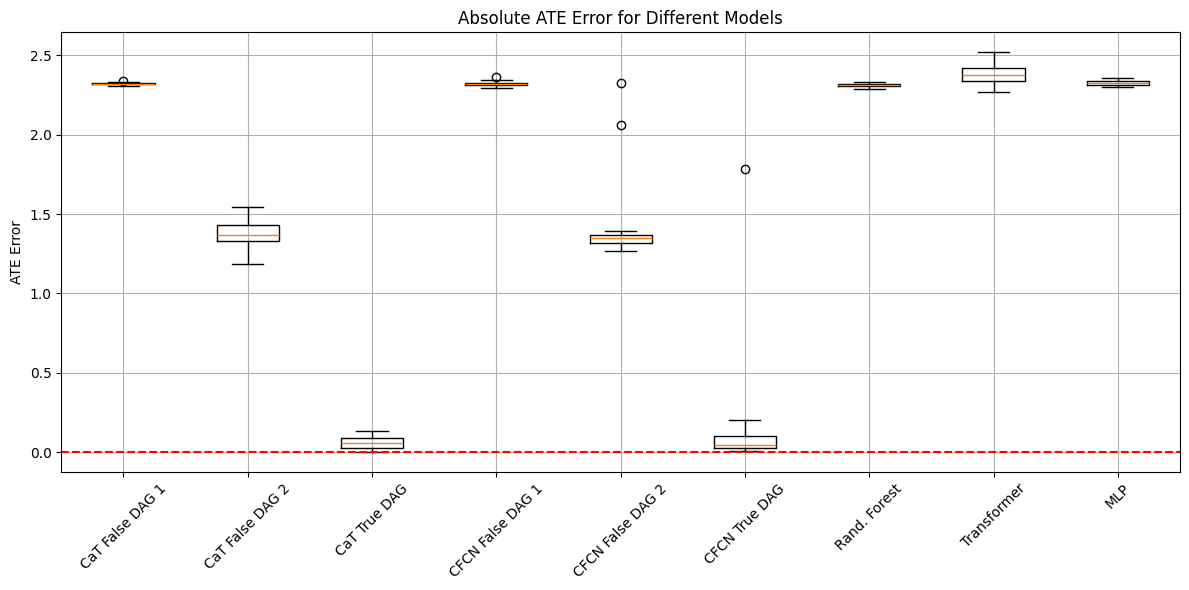

/tmp/ipykernel_152074/665083340.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(mse_data, labels=mse_labels)


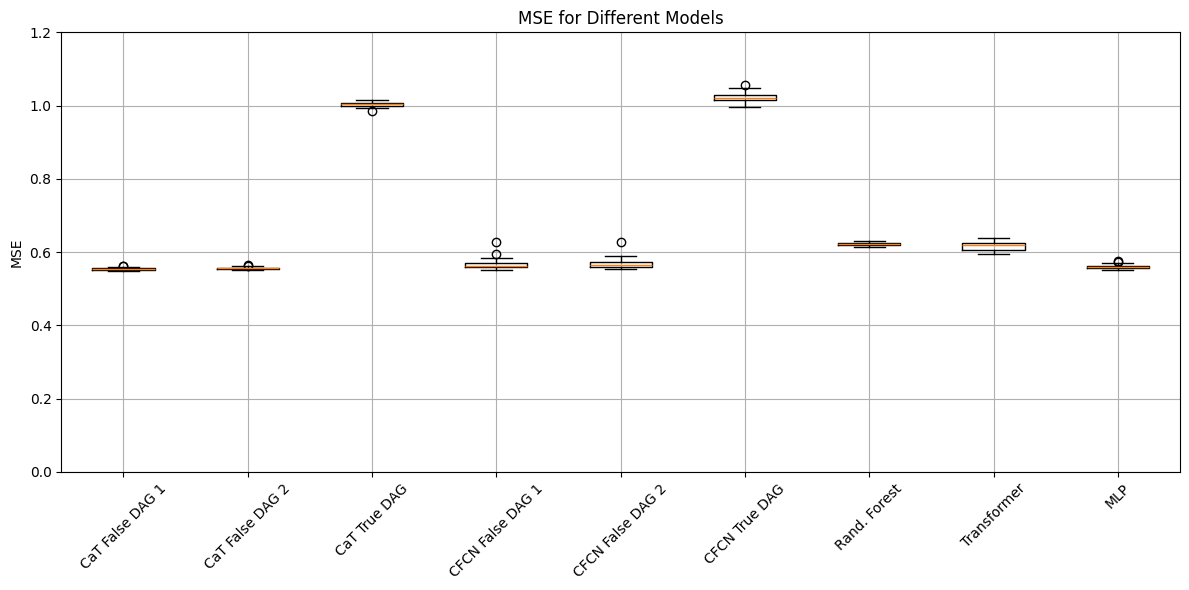

In [18]:

plt.figure(figsize=(12, 6))
plt.boxplot(ate_error_data, labels=ate_error_labels)
plt.axhline(y=0, color='r', linestyle='--', label='True ATE')
plt.title('Absolute ATE Error for Different Models')
plt.ylabel('ATE Error')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.savefig(ate_figname)
plt.show()


plt.figure(figsize=(12, 6))
plt.boxplot(mse_data, labels=mse_labels)
plt.title('MSE for Different Models')
plt.ylabel('MSE')
plt.grid(True)
plt.ylim(0,1.2)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.savefig(mse_figname)
plt.show()

In [65]:
val_data.shape

torch.Size([30000, 4, 1])

In [66]:
shift_var = 'L2'
outcome_var = 'Y'
shift_index = var_names3.index(shift_var)
outcome_index = var_names3.index(outcome_var)
shifted_data = val_data.clone()
input_dim = val_data.shape[1] - 1
# shift the data:
shifted_data[:, shift_index] = shifted_data[:, shift_index] + shifted_data[:, shift_index].std()

In [92]:
# CAT + CFCN
preds_cat = model3(val_data.to(device)).detach().cpu()
preds_cat = preds_cat[:, outcome_index,: ]
preds_cfcn =  model3_cfcn(val_data.to(device)).detach().cpu()
preds_cfcn = preds_cfcn[:, outcome_index,: ]


shift_preds_cat = model3(shifted_data.to(device)).detach().cpu()
shift_preds_cat = shift_preds_cat[:, outcome_index,: ]
shift_preds_cfcn = model3_cfcn(shifted_data.to(device)).detach().cpu()
shift_preds_cfcn = shift_preds_cfcn[:, outcome_index,: ]

# split into X and y for MLP and RF
X = val_data[:, np.arange(val_data.shape[1]) != outcome_index]
y = val_data[:, effect_index, 0]


y_shift = shifted_data[:, outcome_index, 0]
X_shift = shifted_data[:, np.arange(shifted_data.shape[1]) != outcome_index]


In [93]:
# RF
RF_preds = RF.predict(X[:,:,0].detach().cpu().numpy() )
RF_preds_shift = RF.predict(X_shift[:,:,0].detach().cpu().numpy())

# MLP
mlp_preds = MLP.predict(X[:,:,0].detach().cpu().numpy() )
mlp_preds_shift = MLP.predict(X_shift[:,:,0].detach().cpu().numpy())

# transformer
X_trans = X.repeat(1, 1, input_dim)
transformer_preds = transformer(X_trans.to('cpu'))
X_trans_shift = X_shift.repeat(1, 1, input_dim)
transformer_preds_shift = transformer(X_trans_shift.to('cpu'))

In [94]:

mse_cfcn = ((preds_cfcn[:,0] - y)**2).mean()
mse_cat = ((preds_cat[:,0] - y)**2).mean()
mse_rf = ((RF_preds - y.detach().cpu().numpy())**2).mean()
mse_mlp = ((mlp_preds - y.detach().cpu().numpy())**2).mean()
mse_transformer = ((transformer_preds - y)**2).mean()

mse_cfcn_shift = ((shift_preds_cfcn[:,0] - y_shift)**2).mean()
mse_cat_shift = ((shift_preds_cat[:,0] - y_shift)**2).mean()
mse_rf_shift = ((RF_preds_shift - y_shift.detach().cpu().numpy())**2).mean()
mse_mlp_shift = ((mlp_preds_shift - y_shift.detach().cpu().numpy())**2).mean()
mse_transformer_shift = ((transformer_preds_shift - y_shift)**2).mean()



In [95]:
mse_results = {
    'Method': ['CFCN', 'CAT', 'Random Forest', 'MLP', 'Transformer'],
    'MSE Before Shift': [mse_cfcn.detach().cpu().numpy(), mse_cat.detach().cpu().numpy(), mse_rf, mse_mlp, mse_transformer.detach().cpu().numpy()],
    'MSE After Shift': [mse_cfcn_shift.detach().cpu().numpy(), mse_cat_shift.detach().cpu().numpy(), mse_rf_shift, mse_mlp_shift, mse_transformer_shift.detach().cpu().numpy()]
}
df_mse_results = pd.DataFrame(mse_results)
# Display or return the DataFrame
print(df_mse_results)

          Method MSE Before Shift MSE After Shift
0           CFCN        1.0386071       1.0386071
1            CAT        1.0135077       1.0135077
2  Random Forest         0.621411        4.754525
3            MLP         0.559017        5.356762
4    Transformer       0.61662346       6.1916833


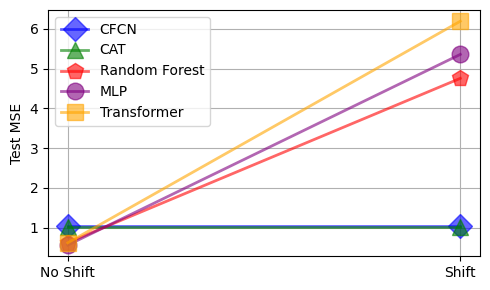

In [113]:
plt.figure(figsize=(5, 3))

methods = df_mse_results['Method']
mse_before_shift = df_mse_results['MSE Before Shift']
mse_after_shift = df_mse_results['MSE After Shift']

# Plot before and after MSE shift for each method with different markers and colors
markers = [ 'D', '^', 'p','o', 's',]
colors = ['blue', 'green', 'red', 'purple', 'orange']

for i, method in enumerate(methods):
    plt.plot(['No Shift', 'Shift'], [mse_before_shift[i], mse_after_shift[i]], 
             marker=markers[i], color=colors[i], ms=12, label=method, alpha=0.6, linewidth=2)
plt.ylabel("Test MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('shift_impact.png', dpi=120)